# Setup

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import FuncFormatter
from datetime import datetime

# SKlearn 
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

# Read Incidents Dataset - Capstone I 
incidents = pd.read_csv('../data/Aggregated/incidents.csv')
incidents.columns

Index(['Incident ID', 'Incident Date', 'Incident Time', 'Day',
       'Incident County Name', 'Incident State', 'Victim ID', 'Gender Desc',
       'Age Range', 'Race', 'Ethnicity Desc', 'Naloxone Administered',
       'Survive', 'Response Desc', 'All Drugs', 'Incident Date ym'],
      dtype='object')

# Pre-processing

## Multi-drug use

In [67]:
incidents['Multiple Drugs'] = 0
incidents.loc[incidents['All Drugs'].str.contains(' | ', regex = False), 'Multiple Drugs'] = 1
incidents[incidents['Multiple Drugs'] == 1].shape

(8050, 17)

## Fentanyl

In [68]:
incidents['Fentanyl'] = 0
incidents.loc[incidents['All Drugs'].str.contains('FENTANYL', regex = False), 'Fentanyl'] = 1
incidents['Fentanyl'].value_counts()

0    13342
1     7255
Name: Fentanyl, dtype: int64

## Year, Month and Age Range

In [69]:
def agerange_weekend(df):
    
    df_cpy = df.copy()
    for i, row in df_cpy.iterrows():
        
        # Weekend Binary Feature
        if row['Day'] in ['Friday', "Saturday", "Sunday"]:
            df_cpy.loc[i,'Weekend_OD'] = 1
        else:
            df_cpy.loc[i,'Weekend_OD'] = 0
        
        # Season Features - Winter, Spring, Summer and Fall
        if row['month'] in [1, 12, 2]:
            df_cpy.loc[i,'Season'] = 'Winter'
            
        elif row['month'] in [3,4, 5]:
            df_cpy.loc[i,'Season'] = 'Spring'
            
        elif row['month'] in [6, 7, 8]:
            df_cpy.loc[i,'Season'] = 'Summer'
            
        elif row['month'] in [9, 10, 11]:
            df_cpy.loc[i,'Season'] = 'Fall' 
        
        # Age Binary feature - over/below 40 years old
        if row['Age Range'] in ['0 - 9', '10 - 14', '15 - 19', '20 - 24','25 - 29', '30 - 39']:
            df_cpy.loc[i,'Over 40'] = 0
        else:    
            df_cpy.loc[i,'Over 40'] = 1
        
    # Ensure dtype for binary features is int
    df_cpy['Over 40'] = df_cpy['Over 40'].astype(int)
    df_cpy['Weekend_OD'] = df_cpy['Weekend_OD'].astype(int)
        
    return df_cpy

In [70]:
incidents["year"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').year)
incidents["month"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').month)

# Fix value typo
incidents["Age Range"] = incidents["Age Range"].apply(lambda x: "10 - 14" if x == "14-Oct" else x)

# Sanity Check
# incidents['Age Range'].value_counts()

incidents2 = agerange_weekend(incidents)
incidents2.head(2)

,Incident ID,Incident Date,Incident Time,Day,Incident County Name,Incident State,Victim ID,Gender Desc,Age Range,Race,...,Response Desc,All Drugs,Incident Date ym,Multiple Drugs,Fentanyl,year,month,Weekend_OD,Season,Over 40
0,1,1/4/2018,0:42:00,Thursday,Delaware,Pennsylvania,1,Male,50 - 59,White,...,NO RESPONSE TO NALOXONE,COCAINE/CRACK | HEROIN,2018,1,0,2018,1,0,Winter,1
1,26,1/26/2018,9:14:00,Friday,Chester,Pennsylvania,5,Male,25 - 29,White,...,None,HEROIN,2018,0,0,2018,1,1,Winter,0


In [22]:
#### Coorlation
corr = X.corrwith(y)
corr_df = pd.DataFrame({'feature':corr.index, 'correlation':corr.values})
corr_df = corr_df.sort_values(by=['correlation'], ascending=False)
corr_df

,feature,correlation
0,Naloxone Administered,0.463989
98,Race_White,0.094373
87,Age Range_25 - 29,0.071291
81,Gender Desc_Male,0.053256
86,Age Range_20 - 24,0.050604
...,...,...
2,Fentanyl,-0.152036
97,Race_Unknown,-0.201583
63,Incident County Name_Philadelphia,-0.218950
83,Age Range_0 - 9,-0.263933


## Chi-Sqaure before one-hot encoding

In [24]:
def label_encode_strings(df):
    """
    Label encodes all the string columns in a pandas DataFrame.
    
    Args:
        df (pandas.DataFrame): The DataFrame to label encode.
    
    Returns:
        pandas.DataFrame: The label encoded DataFrame.
    """
    # Create a new DataFrame to hold the label encoded data
    encoded_df = df.copy()

    # Loop over all columns in the DataFrame
    for col in encoded_df.columns:
        if encoded_df[col].dtype == "object":
            # If the column contains strings, use LabelEncoder to encode them
            le = LabelEncoder()
            encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))
    
    return encoded_df
 



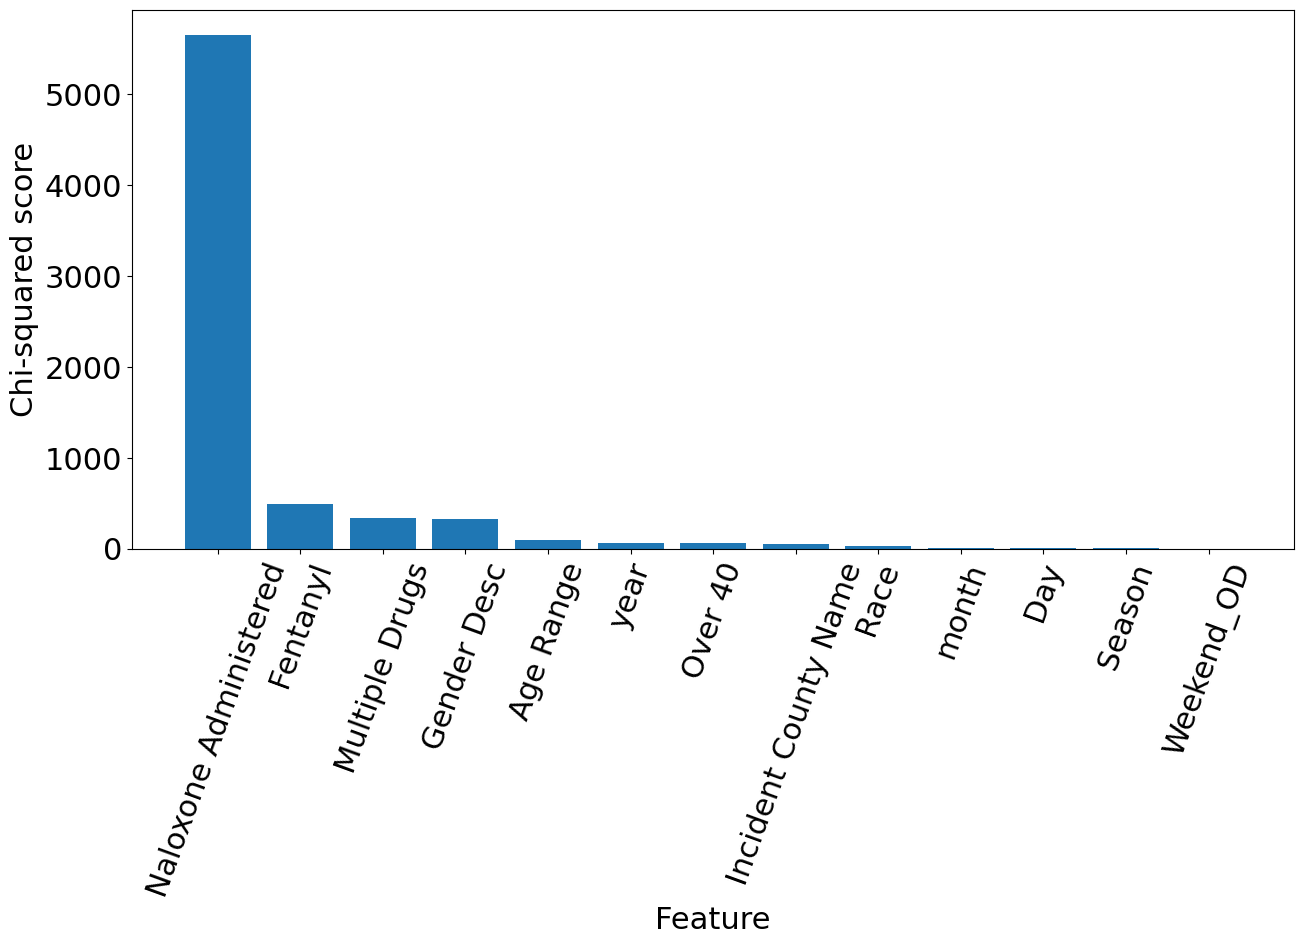

In [36]:
df3 = incidents2[['Day','Incident County Name','Gender Desc','Age Range','Race','Naloxone Administered','Survive','Multiple Drugs','Fentanyl',
                  'year','month','Weekend_OD','Season','Over 40']]
df4 = label_encode_strings(df3)

### Recursive feature elemination
selector = SelectKBest(score_func=f_classif, k=10)
X = df4.drop('Survive', axis=1)  # remove the target column
y = df4['Survive']
X_selected = selector.fit_transform(X, y)

import matplotlib.pyplot as plt
import numpy as np

scores = selector.scores_
features = X.columns
sorted_indices = np.argsort(scores)[::-1]  # Descending order
sorted_scores = scores[sorted_indices]
sorted_features = [features[i] for i in sorted_indices]
fig = figure(figsize = (15, 7))

plt.bar(range(len(features)), sorted_scores)
plt.xticks(range(len(features)), sorted_features, rotation=70)
plt.xlabel('Feature')
plt.ylabel('Chi-squared score')
plt.rcParams.update({'font.size': 22})
plt.show()
fig.savefig("./survival-selection.png", bbox_inches="tight")


## Chi-square after one-hot encoding

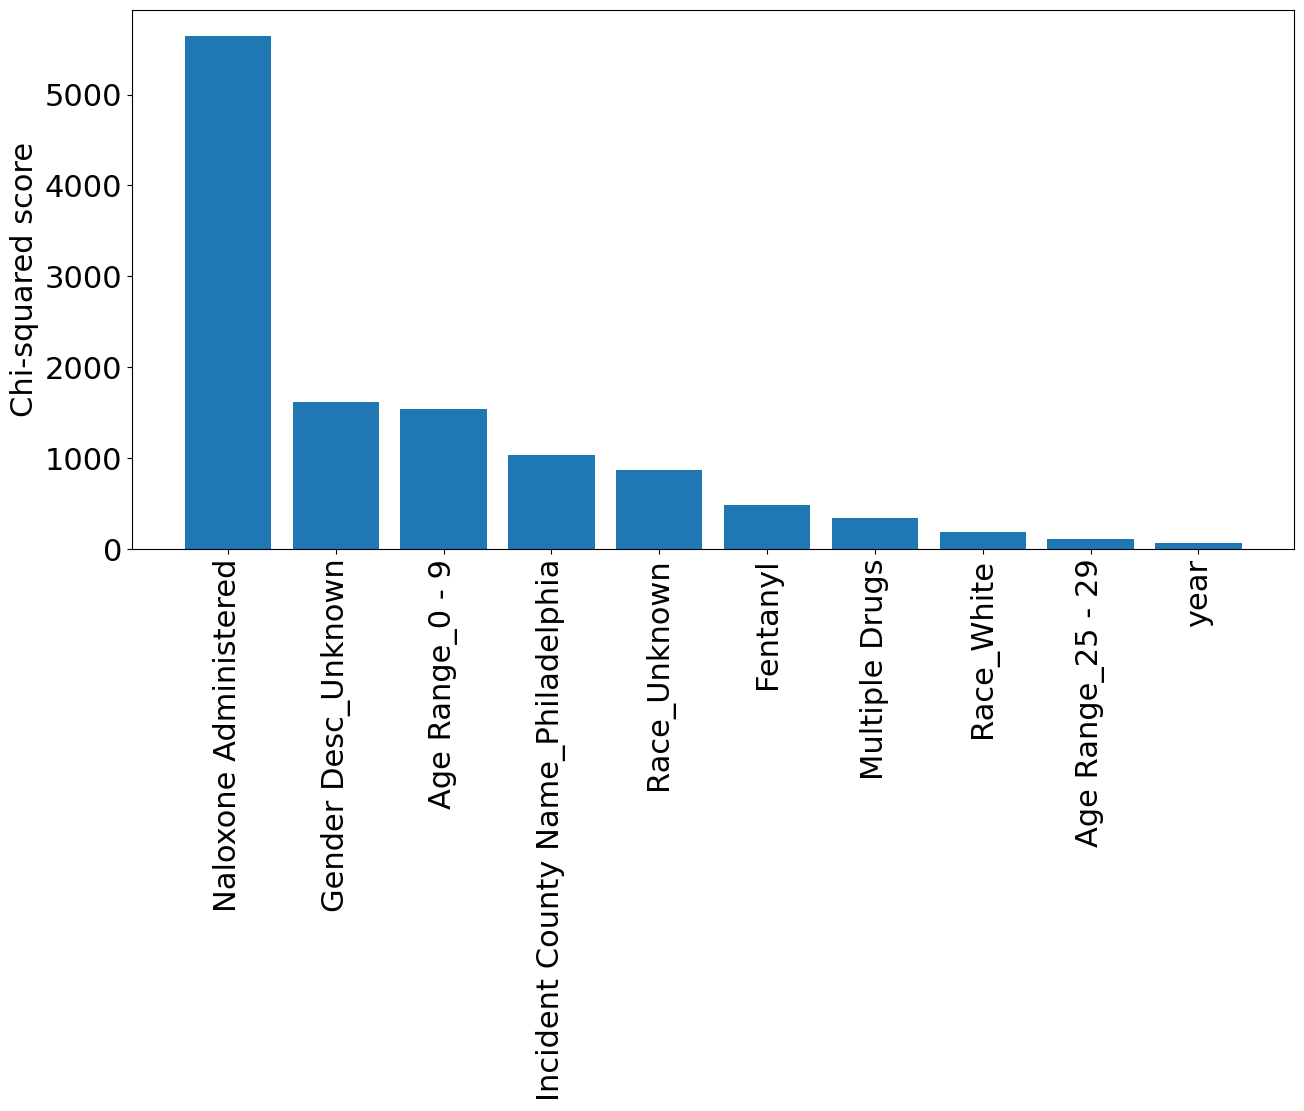

In [21]:
temp_df = incidents2[['Day','Incident County Name','Gender Desc','Age Range','Race','Naloxone Administered','Survive','Multiple Drugs','Fentanyl',
                  'year','month','Weekend_OD','Season','Over 40']]

numeric_cols = temp_df.select_dtypes(include=['float', 'int']).columns
string_cols = temp_df.select_dtypes(include=['object']).columns

temp_df = pd.get_dummies(temp_df, columns=string_cols)

selector = SelectKBest(score_func=f_classif, k=10)
X = temp_df.drop('Survive', axis=1)  # remove the target column
y = temp_df['Survive']
X_selected = selector.fit_transform(X, y)

scores = selector.scores_
feature_names = X.columns
sorted_indices = scores.argsort()[::-1][:10]  # get the top 10 feature indices

fig = figure(figsize = (15, 7))
plt.bar(range(10), scores[sorted_indices])
plt.xticks(range(10), feature_names[sorted_indices], rotation=90)
plt.rcParams.update({'font.size': 22})
plt.ylabel("Chi-squared score")
fig.savefig("./one-hot-encoded-survival.png", bbox_inches="tight")
plt.show()

# Naloxone Administration Feature Selection

In [72]:
def hoursplit(df):
    for i, row in df.iterrows():
        if row['hour'] in['1','2','3','4']:
            df.loc[i, 'time_period'] ='late_evening'
        elif row['hour'] in['5','6','7','8','9']: 
            df.loc[i, 'time_period'] ='early_morning'
        elif row['hour'] in['10','11','12','13','14']: 
            df.loc[i, 'time_period'] ='morning_afternoon'  
        elif row['hour'] in['15','16','17','18','19']: 
            df.loc[i, 'time_period'] ='afternoon_even'
        else:
            df.loc[i, 'time_period'] = 'evening'
    return(df) 

In [88]:
temp_df = incidents2.copy()
temp_df[['hour','min','second']] = temp_df['Incident Time'].str.split(':',expand=True)
temp_df = hoursplit(temp_df.copy())

temp_df['Over 40'] = temp_df['Over 40'].astype(int)
temp_df['Weekend_OD'] = temp_df['Weekend_OD'].astype(int)

temp_df_2 = temp_df[['Day','Incident County Name','Gender Desc','Age Range','Race','Naloxone Administered','Multiple Drugs',
                  'year','month','Weekend_OD','Season','time_period']]

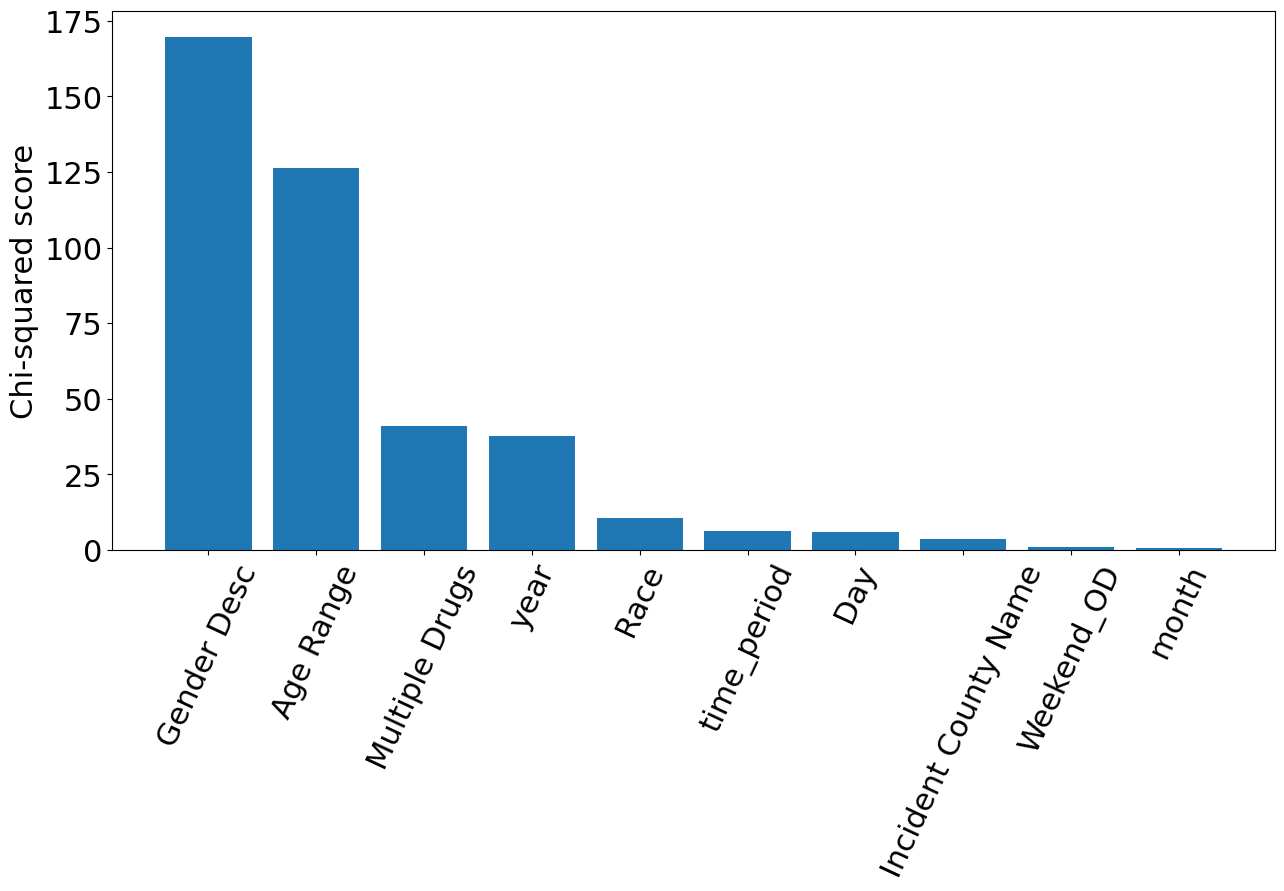

In [95]:
df4 = label_encode_strings(temp_df_2.copy())
selector = SelectKBest(score_func=f_classif, k=10)
X = df4.drop('Naloxone Administered', axis=1)  # remove the target column
y = df4['Naloxone Administered']
X_selected = selector.fit_transform(X, y)

fig = figure(figsize = (15, 7))
scores = selector.scores_
feature_names = X.columns
sorted_indices = scores.argsort()[::-1][:10]  # get the top 10 feature indices
plt.bar(range(10), scores[sorted_indices])
plt.xticks(range(10), feature_names[sorted_indices], rotation=65)
plt.rcParams.update({'font.size': 22})
plt.ylabel("Chi-squared score")
fig.savefig("./Naloxone-selection.png", bbox_inches="tight")
plt.show()

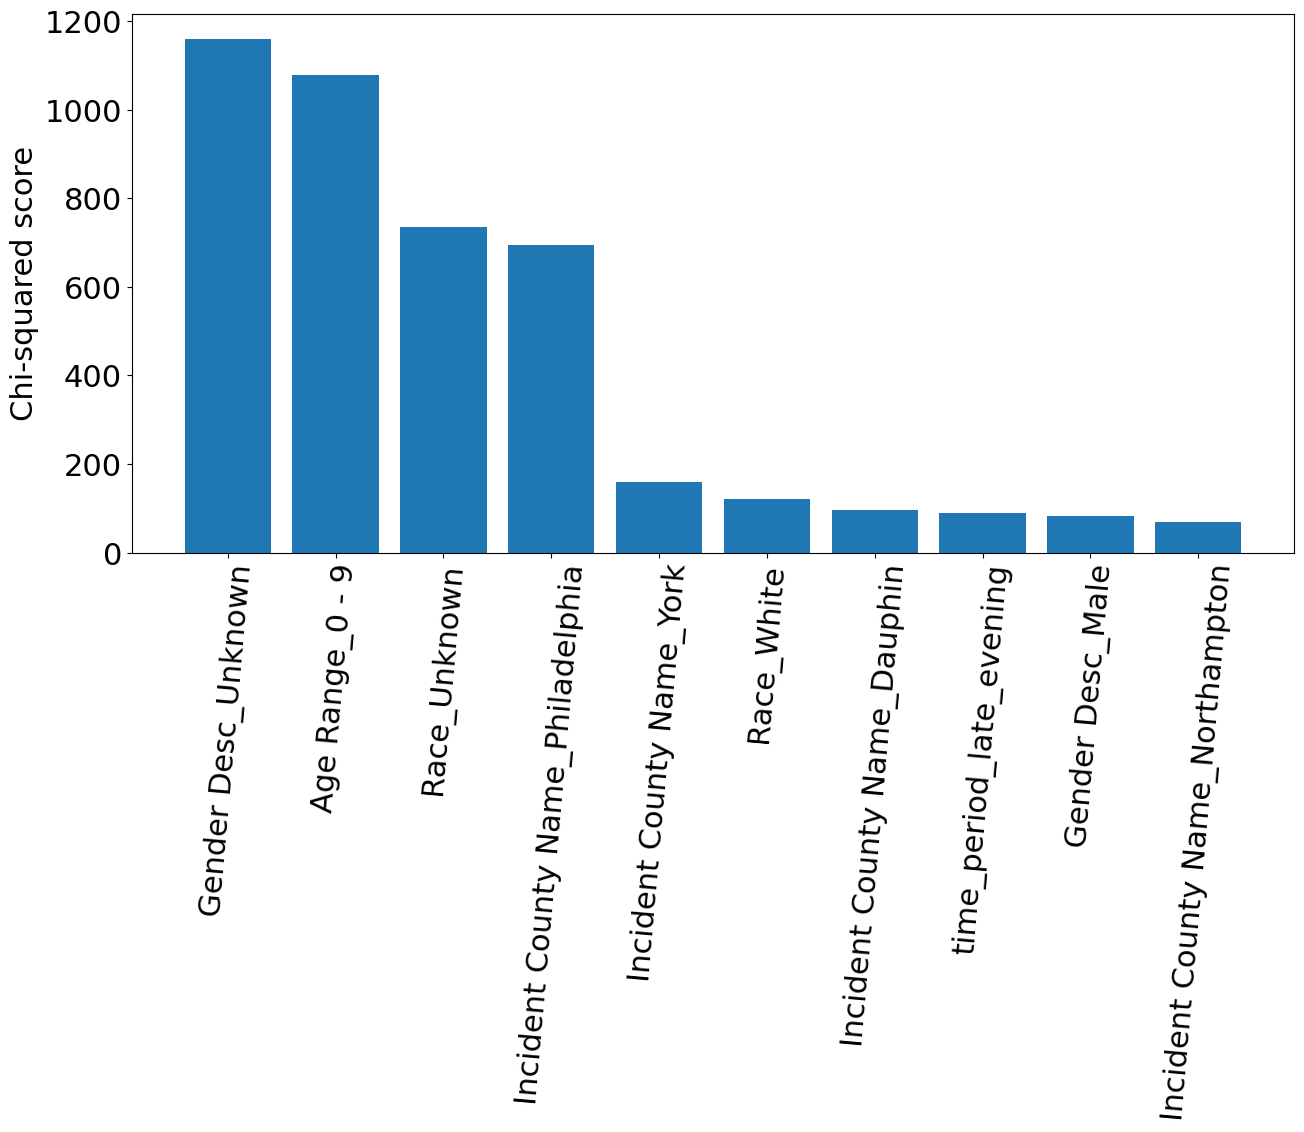

In [94]:
# temp_df_3 = temp_df_2[['Day','Incident County Name','Gender Desc','Age Range','Race','Naloxone Administered','Multiple Drugs',
#                   'year','month','Weekend_OD','Season','time_period']]

numeric_cols = temp_df_2.select_dtypes(include=['float', 'int']).columns
string_cols = temp_df_2.select_dtypes(include=['object']).columns

temp_df_3 = pd.get_dummies(temp_df_2, columns=string_cols)

selector = SelectKBest(score_func=f_classif, k=10)
X = temp_df_3.drop('Naloxone Administered', axis=1)  # remove the target column
y = temp_df_3['Naloxone Administered']
X_selected = selector.fit_transform(X, y)

scores = selector.scores_
feature_names = X.columns
sorted_indices = scores.argsort()[::-1][:10]  # get the top 10 feature indices

fig = figure(figsize = (15, 7))
plt.bar(range(10), scores[sorted_indices])
plt.xticks(range(10), feature_names[sorted_indices], rotation=85)
plt.rcParams.update({'font.size': 22})
plt.ylabel("Chi-squared score")
fig.savefig("./one-hot-encoded-Naloxone.png", bbox_inches="tight")
plt.show()